
# Pseudobatch transformation with uncertainties

This notebook describes how to use the Pseudobatch transformation with error propagation of the measurement uncertainties. This utilizes a Bayesian model which is provided as a precompiled model implemented in the programming language [Stan](https://mc-stan.org/).

## Imports

In [1]:
import logging

from itertools import islice

import arviz as az
import cmdstanpy
import numpy as np
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection
from scipy.special import logit

from pseudobatch.data_correction import pseudobatch_transform
from pseudobatch.datasets import load_standard_fedbatch
from pseudobatch.error_propagation import run_error_propagation

cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

/Users/s143838/.virtualenvs/pseudobatch-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'stan_version_major': '2', 'stan_version_minor': '29', 'stan_version_patch': '2', 'STAN_THREADS': 'false', 'STAN_MPI': 'false', 'STAN_OPENCL': 'false', 'STAN_NO_RANGE_CHECKS': 'false', 'STAN_CPP_OPTIMS': 'false'}


## Loading data

This cell uses the function `load_standard_fedbatch` from pseudobatch's `datasets` module to load a standard dataset. It then adds some columns that will be useful later.

In [2]:
SPECIES = ["Biomass", "Glucose", "Product"]
samples = load_standard_fedbatch(sampling_points_only=True)
samples["v_Feed_interval"] = np.concatenate(
    [np.array([samples["v_Feed_accum"].iloc[0]]), np.diff(samples["v_Feed_accum"])]
)
for species in SPECIES:
    samples[f"c_{species}_pseudobatch"] = pseudobatch_transform(
        measured_concentration=samples[f"c_{species}"],
        reactor_volume=samples["v_Volume"],
        accumulated_feed=samples["v_Feed_accum"],
        concentration_in_feed=100 if species == "Glucose" else 0,
        sample_volume=samples["sample_volume"],
    )
samples

Kc_s  mu_max   Yxs      Yxp     Yxco2        F0  mu0    s_f  sample_volume   
0  0.15     0.3  1.85  0.82151  0.045193  0.062881  0.1  100.0          170.0  \
1  0.15     0.3  1.85  0.82151  0.045193  0.062881  0.1  100.0          170.0   
2  0.15     0.3  1.85  0.82151  0.045193  0.062881  0.1  100.0          170.0   
3  0.15     0.3  1.85  0.82151  0.045193  0.062881  0.1  100.0          170.0   
4  0.15     0.3  1.85  0.82151  0.045193  0.062881  0.1  100.0          170.0   
5  0.15     0.3  1.85  0.82151  0.045193  0.062881  0.1  100.0          170.0   
6  0.15     0.3  1.85  0.82151  0.045193  0.062881  0.1  100.0          170.0   
7  0.15     0.3  1.85  0.82151  0.045193  0.062881  0.1  100.0          170.0   

   timestamp  ...    m_CO2_gas  c_Glucose  c_Biomass  c_Product  c_CO2   
0  10.000000  ...    38.827037   0.075016   1.337852   0.694735    0.0  \
1  17.142857  ...    92.155995   0.075103   2.664023   1.794378    0.0   
2  24.285714  ...   179.754779   0.075053   5.175767   3.877080    0.0   
3  31.428571  ...   317.230058   0.075015   9.612284   7.555778    0.0   
4  38.571429  ...   521.048177   0.075011  16.561967  13.318358    0.0   
5  45.714286  ...   804.712744   0.075009  25.635276  20.841818    0.0   
6  52.857143  ...  1178.794116   0.075033  35.029969  28.631766    0.0   
7  60.000000  ...  1662.311084   0.075012  42.688520  34.982129    0.0   

    mu_true  v_Feed_interval  c_Biomass_pseudobatch  c_Glucose_pseudobatch   
0  0.100014        15.906036               1.337852               0.075016  \
1  0.100091        21.847477               2.732828              -2.505689   
2  0.100047        35.885358               5.582507              -7.777595   
3  0.100013        56.317871              11.403591             -18.546600   
4  0.100010        83.496054              23.294434             -40.544661   
5  0.100008       116.205937              47.584179             -85.480689   
6  0.100029       153.246173              97.201461            -177.272659   
7  0.100011       198.077362             198.556125            -364.778789   

   c_Product_pseudobatch  
0               0.694735  
1               1.840722  
2               4.181762  
3               8.963843  
4              18.732292  
5              38.686567  
6              79.447672  
7             162.711567  

[8 rows x 26 columns]

## Specifying priors

The next cell specifies the prior distributions required for pseudobatch's error propagation function. These are set by choosing values for percentiles. Note that it is also possible to set prior distributions using location and scale parameters, for example:

```
priors = {
    ...
    prior_v0: {"mu": 0, "sigma": 1},
    ...
}
```

In [3]:
priors = {
    "prior_apump": {"pct1": np.log(1 - 0.1), "pct99": np.log(1 + 0.1)},
    "prior_as": {"pct1": logit(0.05), "pct99": logit(0.4)},
    "prior_v0": {"pct1": 1000, "pct99": 1030},
    "prior_cfeed": [{"loc": 0, "scale": 1}, {"pct1": 98, "pct99": 102}, {"loc": 0, "scale": 1}],
}

## Running the error propagation function

In [4]:
idata = run_error_propagation(
    y_concentration=samples[[f"c_{species}" for species in SPECIES]],
    y_reactor_volume=samples["v_Volume"],
    y_feed_in_interval=samples["v_Feed_interval"],
    y_sample_volume=samples["sample_volume"],
    y_concentration_in_feed=[0, 100, 0],
    sd_reactor_volume=0.05,
    sd_concentration=[0.05] * 3,
    sd_feed_in_interval=0.05,
    sd_sample_volume=0.05,
    sd_concentration_in_feed=0.05,
    prior_input=priors,
    species_names=SPECIES
)
idata

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> sample_stats_prior

## Diagnostics

The next cell prints some diagnostic information. By inspecting it we can see that:

* There were no post warmup divergent transitions, indicating that the sampler was able to explore the posterior without significant approximation errors.
* There were no parameters with r_hat values more than 0.01 away from 1, indicating that the chains converged.
* The posterior `mcse_sd` parameters are fairly small.

In [5]:
display(az.summary(idata.sample_stats))
display(az.summary(idata.prior).sort_values("r_hat"))
display(az.summary(idata.posterior).sort_values("r_hat"))

/Users/s143838/.virtualenvs/pseudobatch-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/s143838/.virtualenvs/pseudobatch-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd   
lp              -116.613  4.641 -125.567 -108.514      0.108    0.076  \
acceptance_rate    0.860  0.129    0.624    1.000      0.002    0.001   
step_size          0.391  0.013    0.375    0.406      0.006    0.005   
tree_depth         3.466  0.506    3.000    4.000      0.096    0.068   
n_steps           12.572  5.231    7.000   15.000      0.722    0.514   
diverging          0.000  0.000    0.000    0.000      0.000    0.000   
energy           138.084  6.558  126.165  150.635      0.166    0.118   

                 ess_bulk  ess_tail  r_hat  
lp                 1875.0    2489.0   1.00  
acceptance_rate    4825.0    4000.0   1.00  
step_size             4.0       4.0    inf  
tree_depth           28.0      28.0   1.10  
n_steps              45.0      56.0   1.06  
diverging          4000.0    4000.0    NaN  
energy             1582.0    2067.0   1.00

arviz - WARNING - Array contains NaN-value.
/Users/s143838/.virtualenvs/pseudobatch-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/s143838/.virtualenvs/pseudobatch-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean            sd    hdi_3%   hdi_97%   
v0                         1.014967e+03  6.274000e+00  1003.020  1026.440  \
c[5, Product]              2.525166e+09  1.596903e+11     0.000   382.677   
c[5, Glucose]              2.220015e+10  1.403833e+12     0.000   346.289   
c[5, Biomass]              2.521762e+06  1.333038e+08     0.000   556.668   
c[4, Product]              7.300870e+08  3.772254e+10     0.000  1022.640   
...                                 ...           ...       ...       ...   
apump                     -6.000000e-03  4.400000e-02    -0.092     0.070   
pseudobatch_c[7, Product]  6.206539e+09  3.906427e+11     0.000  2727.340   
pump_bias                           NaN           NaN   -11.833       NaN   
cfeed[Biomass]             0.000000e+00  0.000000e+00     0.000     0.000   
cfeed[Product]             0.000000e+00  0.000000e+00     0.000     0.000   

                              mcse_mean       mcse_sd  ess_bulk  ess_tail   
v0                         5.800000e-02  4.100000e-02   11762.0    2675.0  \
c[5, Product]              2.519860e+09  1.781939e+09    6104.0    3090.0   
c[5, Glucose]              2.215507e+10  1.566714e+10    6059.0    3041.0   
c[5, Biomass]              2.103310e+06  1.487494e+06    7532.0    3018.0   
c[4, Product]              5.951675e+08  4.209284e+08    6743.0    2939.0   
...                                 ...           ...       ...       ...   
apump                      1.000000e-03  1.000000e-03    7492.0    2746.0   
pseudobatch_c[7, Product]  6.164198e+09  4.359074e+09    8877.0    2982.0   
pump_bias                           NaN           NaN       NaN       NaN   
cfeed[Biomass]             0.000000e+00  0.000000e+00    4000.0    4000.0   
cfeed[Product]             0.000000e+00  0.000000e+00    4000.0    4000.0   

                           r_hat  
v0                           1.0  
c[5, Product]                1.0  
c[5, Glucose]                1.0  
c[5, Biomass]                1.0  
c[4, Product]                1.0  
...                          ...  
apump                        1.0  
pseudobatch_c[7, Product]    1.0  
pump_bias                    NaN  
cfeed[Biomass]               NaN  
cfeed[Product]               NaN  

[119 rows x 9 columns]

arviz - WARNING - Array contains NaN-value.
/Users/s143838/.virtualenvs/pseudobatch-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/s143838/.virtualenvs/pseudobatch-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean      sd    hdi_3%   hdi_97%  mcse_mean   
v0                         1013.674   6.047  1002.120  1024.430      0.085  \
c[5, Product]                20.841   1.030    18.947    22.801      0.014   
c[5, Glucose]                 0.075   0.004     0.068     0.082      0.000   
c[5, Biomass]                25.649   1.276    23.197    27.988      0.016   
c[4, Product]                13.328   0.676    12.090    14.615      0.009   
...                             ...     ...       ...       ...        ...   
apump                         0.009   0.033    -0.054     0.070      0.001   
pseudobatch_c[7, Product]   155.983  12.100   133.595   178.295      0.230   
pump_bias                       NaN     NaN   -11.956       NaN        NaN   
cfeed[Biomass]                0.000   0.000     0.000     0.000      0.000   
cfeed[Product]                0.000   0.000     0.000     0.000      0.000   

                           mcse_sd  ess_bulk  ess_tail  r_hat  
v0                           0.060    5069.0    3144.0    1.0  
c[5, Product]                0.010    5480.0    3012.0    1.0  
c[5, Glucose]                0.000    5702.0    3056.0    1.0  
c[5, Biomass]                0.011    6228.0    3694.0    1.0  
c[4, Product]                0.006    5446.0    3471.0    1.0  
...                            ...       ...       ...    ...  
apump                        0.001    2136.0    2454.0    1.0  
pseudobatch_c[7, Product]    0.163    2737.0    3220.0    1.0  
pump_bias                      NaN       NaN       NaN    NaN  
cfeed[Biomass]               0.000    4000.0    4000.0    NaN  
cfeed[Product]               0.000    4000.0    4000.0    NaN  

[119 rows x 9 columns]

## Plotting some modelled quantities

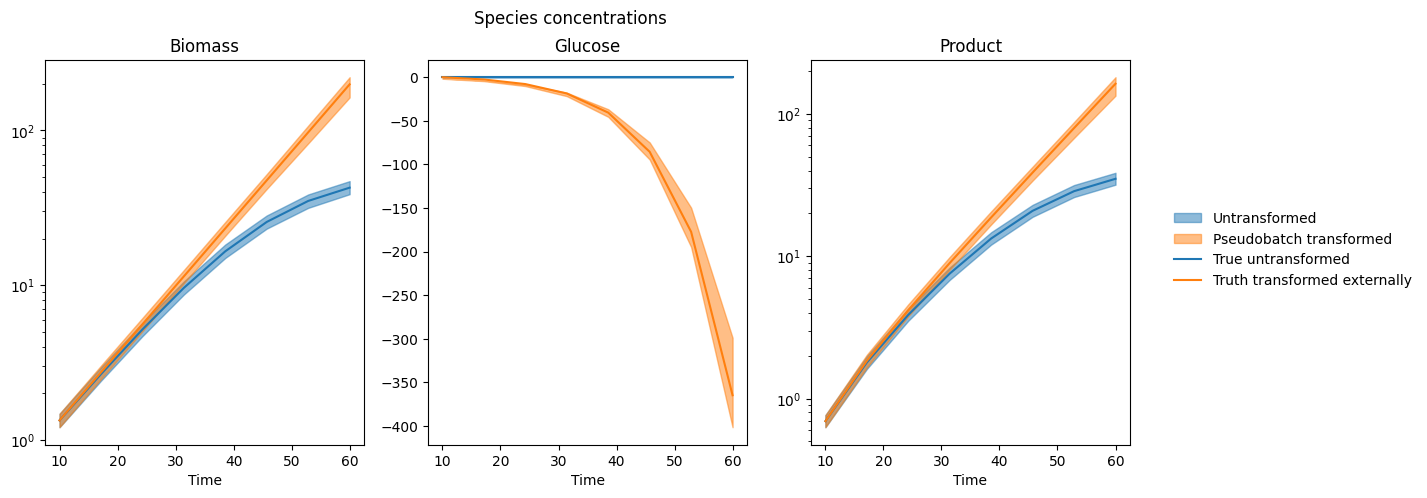

In [6]:
def plot_timecourse_qs(
    ax: plt.Axes,
    varname: str, 
    idata_group: xr.Dataset, 
    timepoints: pd.Series,
    coords: dict,
    quantiles: list = [0.025, 0.975],
    **fill_between_kwargs
) -> PolyCollection:
    var_draws = idata_group[varname]
    for k, v in coords.items():
        if k in var_draws.coords:
            var_draws = var_draws.sel({k:v})
    qs = var_draws.quantile(quantiles, dim=["chain", "draw"]).to_dataframe()[varname].unstack("quantile")
    low = qs[0.025].values
    high = qs[0.975].values
    x = timepoints.values
    return ax.fill_between(x, low, high, **fill_between_kwargs)


f, axes = plt.subplots(1, 3, figsize=[14, 5])
for ax, species in zip(axes, SPECIES):
    pcs = []
    line_patches = []
    for var, color in zip(["c", "pseudobatch_c"], ["tab:blue", "tab:orange"]):
        true_value_colname = "c_" + species if var == "c" else f"c_{species}_pseudobatch"
        pc = plot_timecourse_qs(
            ax,
            var,
            idata.posterior,
            samples["timestamp"],
            {"species": [species]},
            color=color,
            alpha=0.5,
        )
        pcs += [pc]
        line = ax.plot(samples["timestamp"], samples[true_value_colname], color=color)
        line_patches += [line[-1]]
    txt = ax.set(xlabel="Time", title=species)
    if all(samples[true_value_colname] > 0):
        ax.semilogy()

f.suptitle("Species concentrations")
legend = f.legend(
    [*pcs, *line_patches],
    ["Untransformed", "Pseudobatch transformed", "True untransformed", "Truth transformed externally"],
    ncol=1, 
    loc="right", 
    frameon=False,
    bbox_to_anchor = [1.11, 0.5]
)

## Estimating the growth rate

One thing that you might want to do with pseudobatch transformation is to estimate the measured cells' growth rate.

This can be done for each sample from our posterior distribution, giving us an idea of the range of growth rate estimates that are consistent with our model. Even better, since we used a simulated dataset we know that the true growth rate is 0.1, so we can compare our estimated growth rates with the truth.

draw           0         1         2         3         4         5      
slope      0.102516  0.096615  0.101327  0.096538  0.101856  0.100044  \
intercept -0.807900 -0.614030 -0.776267 -0.619113 -0.797399 -0.721281   

draw           6         7         8         9     ...      3990      3991   
slope      0.099655  0.097026  0.099064  0.097570  ...  0.101227  0.100904  \
intercept -0.691591 -0.667151 -0.676970 -0.619378  ... -0.724136 -0.735155   

draw           3992      3993      3994      3995      3996      3997   
slope      0.099847  0.099308  0.099897  0.098900  0.099894  0.099580  \
intercept -0.708653 -0.679298 -0.656992 -0.661648 -0.707765 -0.695189   

draw          3998      3999  
slope      0.10023  0.099364  
intercept -0.70449 -0.685411  

[2 rows x 4000 columns]

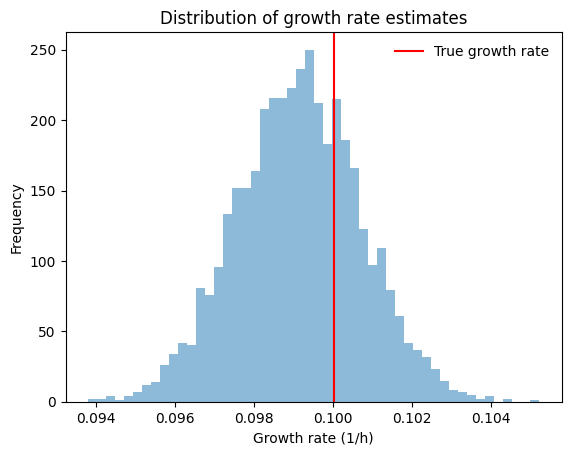

In [7]:
def fit_log_linear_model(y, x):
    logy = np.log(y.values)
    slope, intercept = np.polyfit(x, logy, deg=1)
    return xr.DataArray([slope, intercept])

growth_coeffs = pd.DataFrame(
    idata.posterior["pseudobatch_c"]
    .sel(species="Biomass")
    .stack(chaindraw=("chain", "draw"))
    .groupby("chaindraw")
    .map(fit_log_linear_model, x=samples["timestamp"], shortcut=True)
    .values, 
    columns=["slope", "intercept"]
)
growth_coeffs.index.name = "draw"

display(growth_coeffs.T)

f, ax = plt.subplots()
hist = ax.hist(growth_coeffs["slope"], bins=50, alpha=0.5)
vline = ax.axvline(samples["mu_true"].iloc[0], c="red", label="True growth rate")
txt = ax.set(
    xlabel="Growth rate (1/h)", 
    ylabel="Frequency", 
    title="Distribution of growth rate estimates"
)
leg = ax.legend(frameon=False)


# the 0.025, 0.5 and 0.975 quantiles of the fitted slopes
# print(fitted_growth_rates.slope.quantile([0.025, 0.5, 0.975]))

## Estimating yield coefficients

Glucose yield coefficients:


0         1         2         3         4         5      
slope     -1.744210 -1.757008 -1.741915 -1.723624 -1.871941 -1.838772  \
intercept -2.587623  1.628419 -0.189456 -0.116613  2.007992  2.594703   

               6         7         8         9     ...      3990      3991   
slope     -1.823377 -1.836021 -1.699397 -2.036570  ... -1.845025 -1.872864  \
intercept  2.372684  0.084090  0.129974  4.094919  ... -1.764112 -1.661884   

               3992      3993      3994      3995      3996      3997   
slope     -1.875026 -1.919493 -1.854989 -1.886462 -1.896649 -1.864343  \
intercept  3.475286  4.223898 -0.092433 -1.238829  1.127363  1.162724   

               3998      3999  
slope     -1.842283 -1.924881  
intercept -0.245896  3.203416  

[2 rows x 4000 columns]

Product yield coefficients:


0         1         2         3         4         5      
slope      0.717567  0.830149  0.799137  0.811471  0.820391  0.820898  \
intercept  2.035210 -0.845795 -0.920503  0.366229 -1.117119 -1.476975   

               6         7         8         9     ...      3990      3991   
slope      0.781038  0.815743  0.803372  0.897239  ...  0.833248  0.790404  \
intercept -0.584068  0.767538 -0.163943 -1.097187  ...  0.044753  1.346261   

               3992      3993      3994      3995      3996      3997   
slope      0.889563  0.877858  0.808814  0.822912  0.862858  0.836267  \
intercept -2.497430 -2.395350  0.753787  0.738677 -0.983234 -1.065378   

               3998      3999  
slope      0.825557  0.881137  
intercept -0.643284 -1.157595  

[2 rows x 4000 columns]

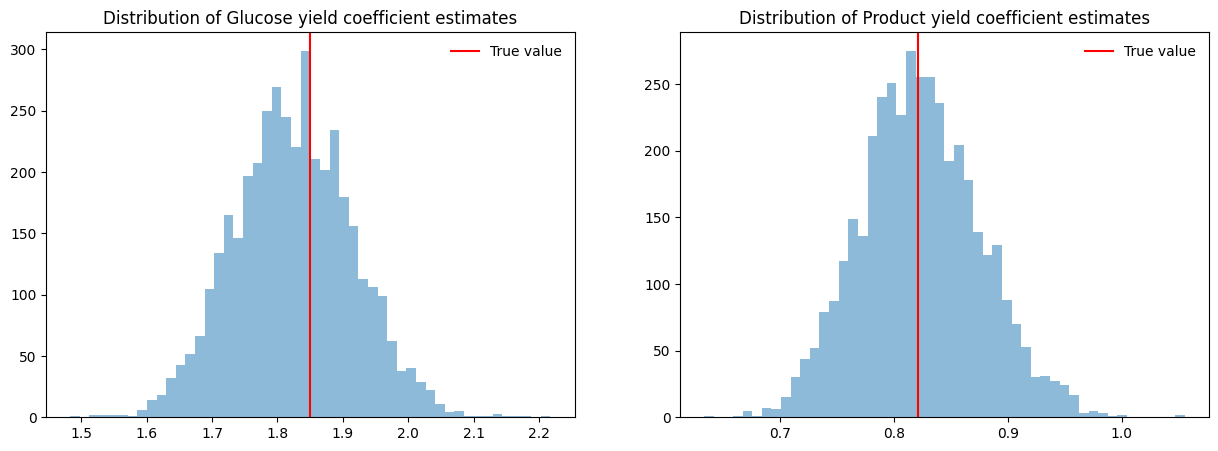

In [8]:
def fit_linear_model(y, x):
    slope, intercept = np.polyfit(x, y, deg=1)
    return xr.DataArray([slope, intercept])

yield_dfs = {}

for species in ["Glucose", "Product"]:
    yield_dfs[species] = pd.DataFrame(
        idata.posterior["pseudobatch_c"]
        .sel(species=["Biomass", species])
        .stack(chaindraw=["chain", "draw"])
        .groupby("chaindraw")
        .map(lambda arr: fit_linear_model(arr.sel(species=species), arr.sel(species="Biomass")))
        .values,
        columns=["slope", "intercept"]
    )
print("Glucose yield coefficients:")
display(yield_dfs["Glucose"].T)
print("Product yield coefficients:")
display(yield_dfs["Product"].T)

f, axes = plt.subplots(1, 2, figsize=[15, 5])
for ax, species, true_value_colname in zip(axes, ["Glucose", "Product"], ["Yxs", "Yxp"]):
    hist = ax.hist(np.abs(yield_dfs[species]["slope"]), bins=50, alpha=0.5)
    vline = ax.axvline(samples[true_value_colname].iloc[0], color="red", label="True value")
    title = ax.set(title=f"Distribution of {species} yield coefficient estimates")
    leg = ax.legend(frameon=False)
